# Face Alignment

## Архитектура Stacked Hourglass Network

**Hourglass** — это U-Net-подобная структура, которая сначала уменьшает разрешение изображения, затем восстанавливает его обратно. Такая структура напоминает по форме песочные часы (hourglass).

**Stacked Hourglass Network** состоит Hourglass-блоков, каждый из которых старается уточнять результат предыдущего. Несмотря на то, что она придумана в 2016 году, до сих пор используется во многих исследовательских проектах для задачи обнаружения ключевых точек.

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.49.50_PM.png)

### Hourglass module

Посмотрим подробнее на структуру **отдельного Hourglass-блока**

![retrt](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-23_at_12.50.12_PM.png)

Каждый бокс в этой схеме - это Residual block, который отвечает за извлечение признаков на разных уровнях детализации (вспоминаем про ResNet). Причем, каждый такой блок иммеет одинаковую размерность на входе и на выходе.

Downsampling и upsampling можно делать разными способами.

*   Для Downsampling: nn.MaxPool2d или nn.Conv2d
*   Для Upsampling: nn.Upsample или nn.ConvTranspose2d

Основная разница: maxpool и upsample - необучаемые слои в отличие от сверток. Это может как быть как минусом, так и плюсом: чем больше параметров - тем медленее идет процесс обучения (при этом не факт, что результаты будут лучше).

То есть, идейно все практически также как было в U-net: полностью симметричная архитектура, сначала идет преобразование в более низкоразмерное пространство, а потом декодирование обратно с пробросами результатов из соотвествующих слоев энкодера. Разница лишь в том, что теперь каждый кирпичик - это Residual block.

А вот реализация ResidualBlock вам в помощь!

Но можете ее править под себя, если очень хочется.

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

При построении архитектуры Hourglass-блоков **не обязательно полностью повторять архитектуру**, которая представлена на картинке из статьи. Вы можете добавлять больше или меньше модулей, некоторые блоки вообще можно не использовать. В целом, это творческая задача и вы вольны делать так, как вам самим хочется. **Главное - чтобы ваша реализация соотвествовала изначальной идее Hourglass, и итоговые результаты были достаточно хорошими.**

### Stacked Hourglass Network

Как и было сказано ранее, Stacked Hourglass - это набор одинаковых Hourglass блоков (см. схематический рисунок в начале ноутбука). Но что это за блок между каждыми двумя Hourglass? Чтобы ответить на этот вопрос, нужно сначала разобраться с тем, что мы будем получать на выходе такой нейронной сети.

Предсказывать ключевые точки лица можно поразному. Есть два основных подхода:

1.   Регрессия - предсказывает координаты точек лица напрямую -> $(N, x, y)$.
2.   Heatmap - предсказывает карту вероятностей на выходе, а наиболее подходящие точки находятся через argmax

Не вдваясь в подробности, можно просто сказать, что Heatmap-подход показал себя лучше из-за своей устойчивости к шумам и начальным условиям. В качестве функции потерь в таком случае используют обычный **MSE loss**.

В Stacked Hourglass **используется именно heatmap-подход**. И на выходе каждого Hourglass-блока находится слой (голова), который создает heatmap нужного размера. Обычно это какие-то стандартные варианты по типу *Conv -> BatchNorm -> Relu -> Conv* или просто *Conv*. Каждая heatmap'a прокидывается на следующую голову, и они суммируются, и так, пока слои не закончатся.

Такой подход нужен для реализации **Intermediate Supervision**. Если говорить простыми словами, то это такой вариант обучения нейронной сети, когда мы подсчитываем лосс не только по финальному выходу сети, а также на некоторых промежуточных слоях (головах). Градиенты в этом случае тоже распространяются не только через последний выход, но и через промежуточные уровни. Эти головы не влияют на финальное предсказание напрямую, но помогают модели быстрее и лучше учиться. На практике это означет следующее:

Нужно посчитать лосс (таргет для всех одинаковый) для каждой головы отдельно, а потом просуммировать. Далее Pytorch сам построит за вас весь граф вычислений и правильно запустит везде градиенты. В коде это выглядит так:

```
outputs = model(image)  # outputs — список из N heatmaps от разных голов
losses = [loss_function(output, target) for output in outputs]
total_loss = sum(losses)
total_loss.backward()
optimizer.step()
```

Подведем **итоги по архитектуре**.

Stacked Hourglass состоит из Hourglass-блоков, после каждого такого блока идет голова, которая предсказывает heatmap'у. Каждая heatmap'а суммируется с предыдущей. Градиенты при обучении текут с каждой головы, а не только через последний выход сети.

Подробно про Stacked Hourglass Network можно прочитать в [оригинальной статье](https://arxiv.org/pdf/1603.06937).

## Датасет

Есть множество датасетов для этой задачи, но для наших целей должно хватить и [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). К сожалению или к счастью в разметке там всего 5 точек

1.   Левый глаз
2.   Правый глаз
3.   Нос
4.   Левый уголок рта
5.   Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы. Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек. Вот вам функции в помощь. Можете их тоже редактивовать под себя, если нужно.

In [19]:
import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark: (x, y) — координаты точки
    :param sigma: стандартное отклонение гаусса
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y) ** 2 + (xx - x) ** 2) / (2 * sigma ** 2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN)]
    :param sigma: параметр гауссовского ядра
    :return: numpy-массив heatmap'ов размера [N, H, W]
    """
    heatmaps = []
    for landmark in landmarks:
        hm = create_heatmap(image_shape, landmark, sigma=sigma)
        heatmaps.append(hm)
    return np.array(heatmaps)

In [4]:
from google.colab import drive, output
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!gdown 1tBZkHs2T_MtV9JbA1JpZpf9KHCGQlY_Y
!unzip -q dataset_500.zip

Downloading...
From (original): https://drive.google.com/uc?id=1jpn53D-06GJpleuVwOWPeWQngFSytv37
From (redirected): https://drive.google.com/uc?id=1jpn53D-06GJpleuVwOWPeWQngFSytv37&confirm=t&uuid=7ff92c3f-1afa-49bf-aad8-8fecd346633d
To: /content/dataset_500.zip
100% 1.37G/1.37G [00:11<00:00, 117MB/s] 


In [11]:
!ls

 dataset_500   dataset_500.zip	 gdrive   sample_data  'view?usp=drive_link'


/tmp/ipython-input-7-3049102111.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bbox = pd.read_csv(bbox_path, delim_whitespace=True, header=1)
/tmp/ipython-input-7-3049102111.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_lm = pd.read_csv(landmarks_path, delim_whitespace=True, header=1)


Выбрано изображение: 043264.jpg


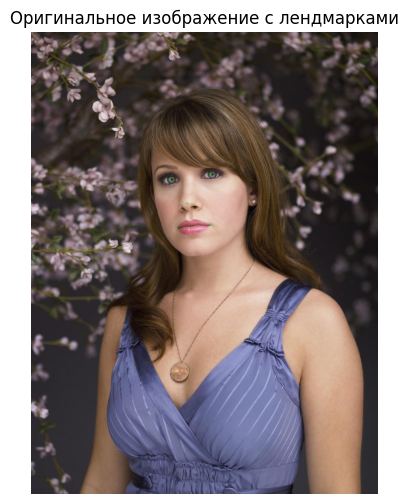

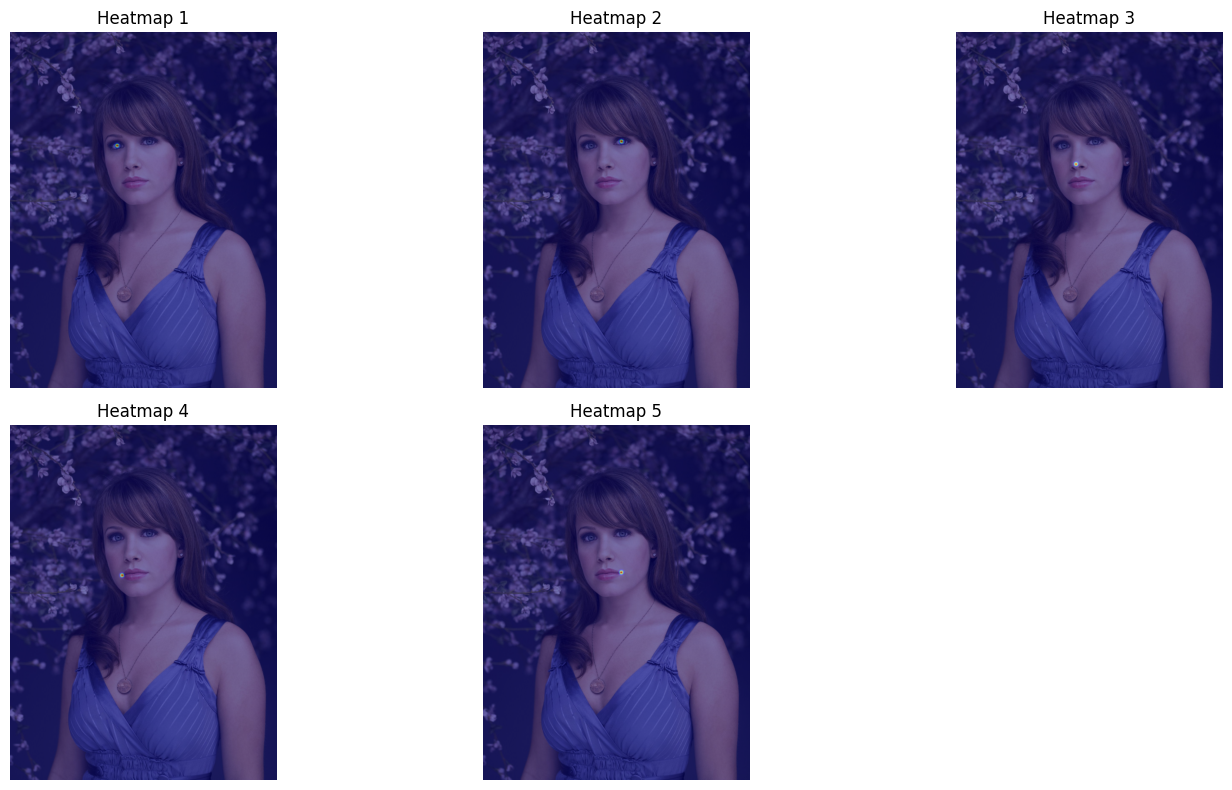

In [7]:
# Посмотрим на датасет
import cv2
import torch


# === Пути ===
img_dir = r"/content/dataset_500/Wild/train"
bbox_path = r"/content/dataset_500/list_bbox_celeba.txt"
landmarks_path = r"/content/dataset_500/list_landmarks_celeba.txt"

# === Загружаем bbox и landmarks ===
df_bbox = pd.read_csv(bbox_path, delim_whitespace=True, header=1)
df_lm = pd.read_csv(landmarks_path, delim_whitespace=True, header=1)

# === Выбираем изображение ===
all_images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
image_name = random.choice(all_images)  # Или image_name = '000001.jpg'
print("Выбрано изображение:", image_name)

# === Получаем bbox и landmarks ===
row_bbox = df_bbox[df_bbox['image_id'] == image_name].iloc[0]
row_lm = df_lm[df_lm['image_id'] == image_name].iloc[0]

# === Загружаем изображение ===
image_path = os.path.join(img_dir, image_name)
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h_img, w_img = image_rgb.shape[:2]

# === Собираем landmarks (5 штук) ===
landmarks = np.array([
    [row_lm['lefteye_x'], row_lm['lefteye_y']],
    [row_lm['righteye_x'], row_lm['righteye_y']],
    [row_lm['nose_x'], row_lm['nose_y']],
    [row_lm['leftmouth_x'], row_lm['leftmouth_y']],
    [row_lm['rightmouth_x'], row_lm['rightmouth_y']],
])

# === Визуализация: оригинал с лендмарками ===
image_disp = image_rgb.copy()
for (lx, ly) in landmarks.astype(int):
    cv2.circle(image_disp, (lx, ly), radius=3, color=(0, 255, 0), thickness=-1)

plt.figure(figsize=(10, 6))
plt.imshow(image_disp)
plt.title("Оригинальное изображение с лендмарками")
plt.axis("off")
plt.show()

# === Создаём heatmaps на всём изображении ===
heatmaps = landmarks_to_heatmaps((h_img, w_img), landmarks, sigma=6)  # больше sigma = мягче

# === Визуализация heatmaps ===
plt.figure(figsize=(15, 8))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image_rgb)
    plt.imshow(heatmaps[i], cmap='jet', alpha=0.5)  # наложение heatmap
    plt.title(f"Heatmap {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Сам по себе CelebA избыточно большой для нашей задачи, поэтому можете использовать только его часть. Также, имеет смысл заранее кропнуть картинки таким образом, чтобы на них остались только лица, ну или по крайней мере минимум всего остального.

## Выравнивание по предсказанным точкам

Существует множество вариантов, как по полученным точкам правильно преобразовать картинку. Главное, что вам нужно понимать - **это задача классического компьютерного зрения** и решается при помощи математики, без нейронок. Вдаваться в подробности конкретных алгоритмов мы не будем.

Можно использовать аффинное преобразование, тогда потребуется только 3 точки, можно, например, искать матрицу гомографии, где может быть использовано больше точек, а может быть, есть еще что-то. Реализовывать эти алгоритмы самим не нужно. Достаточно провести небольшой ресерч и найти готовое решение (но **не готовую нейронку для выравнивания**), лишь бы оно работало. Количество используемых точек тоже выбирайте сами, подойдет любой вариант. Условный ориентир для поиска - библиотека **opencv**.

# План заданий

По итогу, в этом блоке у вас следующие задачи:


*   Реализовать Hourglass блок
*   Реализовать Stacked Hourglass
*   Подготовить датасет, преобразовав точки в Heatmap'ы
*   Обучить модель
*   Найти или реализовать функцию, которая бы по предсказанным ключевым точкам делала бы выравнивание лица на картинке (face alignment)

**P.S. Не забывайте сохранять модели после обучения и выводите промежуточные результаты на экран**



**Удачи! У вас всё получится 💗!**

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os
from PIL import Image, ImageDraw

In [21]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch
import numpy as np
import cv2

class WildLandmarksDataset(Dataset):
    def __init__(self, img_dir, bbox_df, landmarks_df, sigma=1, transform=None):
        self.img_dir = img_dir
        self.bbox_df = bbox_df.set_index("image_id")
        self.landmarks_df = landmarks_df.set_index("image_id")
        self.image_list = sorted(os.listdir(img_dir))
        self.sigma = sigma
        self.transform = transform
        self.target_size = (160, 192)  # (width, height)
        self.landmark_keys = ['lefteye', 'righteye', 'nose', 'leftmouth', 'rightmouth']

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # === Загружаем изображение ===
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # === Получаем bbox ===
        bbox = self.bbox_df.loc[img_name]
        x, y, w, h = int(bbox['x_1']), int(bbox['y_1']), int(bbox['width']), int(bbox['height'])

        # === Обрезаем по bbox ===
        image_crop = image_rgb[y:y+h, x:x+w]

        # === Получаем landmarks и сдвигаем по bbox ===
        row = self.landmarks_df.loc[img_name]
        landmarks = np.array([
            [row['lefteye_x'], row['lefteye_y']],
            [row['righteye_x'], row['righteye_y']],
            [row['nose_x'], row['nose_y']],
            [row['leftmouth_x'], row['leftmouth_y']],
            [row['rightmouth_x'], row['rightmouth_y']],
        ], dtype=np.float32)

        landmarks_crop = landmarks - np.array([x, y], dtype=np.float32)

        # === Масштабирование (crop → 160x192)
        crop_h, crop_w = image_crop.shape[:2]
        scale_x = self.target_size[0] / crop_w
        scale_y = self.target_size[1] / crop_h
        landmarks_resized = landmarks_crop.copy()
        landmarks_resized[:, 0] *= scale_x
        landmarks_resized[:, 1] *= scale_y

        # === Ресайз изображения
        image_resized = cv2.resize(image_crop, self.target_size)

        # === Преобразуем в тензор
        if self.transform:
            image_tensor = self.transform(Image.fromarray(image_resized))
        else:
            image_np = image_resized.astype(np.float32) / 255.0
            image_tensor = torch.tensor(image_np).permute(2, 0, 1)

        # === Создаём heatmaps (на 1/4 разрешения)
        heatmap_size = (self.target_size[1] // 4, self.target_size[0] // 4)  # (H, W)
        heatmaps = self.landmarks_to_heatmaps(heatmap_size, landmarks_resized / 4.0)
        heatmaps = torch.tensor(heatmaps, dtype=torch.float)

        return image_tensor, heatmaps  # можно вернуть img_name для отладки

    def create_heatmap(self, size, landmark):
        x, y = landmark
        h, w = size
        x = min(max(0, int(x)), w - 1)
        y = min(max(0, int(y)), h - 1)
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        heatmap = np.exp(-((xx - x) ** 2 + (yy - y) ** 2) / (2 * self.sigma ** 2))
        return heatmap

    def landmarks_to_heatmaps(self, size, landmarks):
        return np.array([self.create_heatmap(size, pt) for pt in landmarks])


In [10]:
import torch.nn.functional as F

bbox_df=pd.read_csv(r"/content/dataset_500/list_bbox_celeba.txt", delim_whitespace=True, header=1)
landmarks_df=pd.read_csv(r"/content/dataset_500/list_landmarks_celeba.txt", delim_whitespace=True, header=1)

train_dir = r"/content/dataset_500/Wild/train"
val_dir = r"/content/dataset_500/Wild/val"
test_dir = r"/content/dataset_500/Wild/test"


# Создаем датасет
dataset_train = WildLandmarksDataset(train_dir, bbox_df, landmarks_df, sigma=1)
dataset_val = WildLandmarksDataset(val_dir, bbox_df, landmarks_df, sigma=1)
dataset_test = WildLandmarksDataset(test_dir, bbox_df, landmarks_df, sigma=1)

/tmp/ipython-input-10-500517217.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bbox_df=pd.read_csv(r"/content/dataset_500/list_bbox_celeba.txt", delim_whitespace=True, header=1)
/tmp/ipython-input-10-500517217.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  landmarks_df=pd.read_csv(r"/content/dataset_500/list_landmarks_celeba.txt", delim_whitespace=True, header=1)


In [17]:
# DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Image batch shape: torch.Size([64, 3, 192, 160])
Heatmaps batch shape: torch.Size([64, 5, 48, 40])


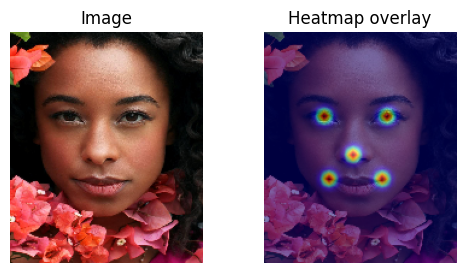

In [18]:
### Проверем что получается

# Берём первый батч из loader
images, heatmaps = next(iter(val_loader))

print(f"Image batch shape: {images.shape}")     # [B, 3, 192, 160]
print(f"Heatmaps batch shape: {heatmaps.shape}") # [B, 5, 48, 40]

# Upsample heatmaps до 192x160
heatmaps_upsampled = F.interpolate(heatmaps, size=(192, 160), mode='bilinear', align_corners=False)

# Визуализация
image = images[0].permute(1, 2, 0).numpy()  # [3,192,160] -> [192,160,3]
heatmap_sum = heatmaps_upsampled[0].sum(dim=0).numpy()  # [192,160]

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(heatmap_sum, cmap='jet', alpha=0.5)
plt.title("Heatmap overlay")
plt.axis('off')

plt.show()

In [22]:
### Используем реализацию Hourglass из приведенной статьи
### https://github.com/princeton-vl/pytorch_stacked_hourglass

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

class Hourglass(nn.Module):
    def __init__(self, depth, f, increase=0):
        """
        depth: глубина hourglass (≥1)
        f: число каналов
        increase: увелечение числа каналов на глубине
        """
        super().__init__()
        self.depth = depth
        nf = f + increase

        self.up1 = ResidualBlock(f, f)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1 = ResidualBlock(f, nf)

        # Рекурсия
        if depth > 1:
            self.low2 = Hourglass(depth - 1, nf)
        else:
            self.low2 = ResidualBlock(nf, nf)

        self.low3 = ResidualBlock(nf, f)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        #print(x.shape)
        up1 = self.up1(x)
        pool1 = self.pool1(x)
        low1 = self.low1(pool1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2 = self.up2(low3)
        #print(up1.shape, up2.shape)
        return up1 + up2


class Merge(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.conv = nn.Conv2d(x_dim, y_dim, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class HeatmapLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, gt):
        #print('loss', pred.shape, gt.shape)
        #l = ((pred - gt)**2)
        #l = l.mean(dim=3).mean(dim=2).mean(dim=1)
        #return l
        return ((pred - gt) ** 2).mean()



class LandmarksNet(nn.Module):
    def __init__(self, nstack=4, inp_dim=128, oup_dim=5, increase=0):
        super().__init__()
        """
        nstack: число HourGlass блоков
        inp_dim: число входных каналов (обычно 256)
        oup_dim: число выходных каналов (число keypoints)
        increase: увелечение числа каналов на глубине
        """

        self.nstack = nstack
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, inp_dim)
        )

        self.hgs = nn.ModuleList([nn.Sequential(Hourglass(depth=3, f=inp_dim),) for i in range(nstack)])

        self.features = nn.ModuleList([nn.Sequential(
            ResidualBlock(inp_dim, inp_dim),
            nn.Conv2d(inp_dim, inp_dim, kernel_size=1)) for i in range(nstack)])

        self.outs = nn.ModuleList([nn.Conv2d(inp_dim, oup_dim, kernel_size=1) for i in range(nstack)])  # 5 heatmaps каналов
        self.merge_features = nn.ModuleList( [Merge(inp_dim, inp_dim) for i in range(nstack-1)] )
        self.merge_preds = nn.ModuleList( [Merge(oup_dim, inp_dim) for i in range(nstack-1)] )
        self.nstack = nstack
        self.heatmapLoss = HeatmapLoss()

    def forward(self, x):
        #print(x.shape)
        x = self.pre(x)
        #print(x.shape)
        combined_hm_preds = []
        for i in range(self.nstack):
            hg = self.hgs[i](x)
            feature = self.features[i](hg)
            preds = self.outs[i](feature)
            combined_hm_preds.append(preds)
            if i < self.nstack - 1:
                x = x + self.merge_preds[i](preds) + self.merge_features[i](feature)
        return torch.stack(combined_hm_preds, 1)

    def calc_loss(self, combined_hm_preds, heatmaps):
        #combined_loss = []
        #for i in range(self.nstack):
            #combined_loss.append(self.heatmapLoss(combined_hm_preds[0][:,i], heatmaps))
            #combined_loss.append(self.heatmapLoss(combined_hm_preds[:][:, i], heatmaps))
        #combined_loss = torch.stack(combined_loss, dim=1)
        #return combined_loss
        total_loss = 0.0
        for i in range(self.nstack):
            pred = combined_hm_preds[:, i]  # [B, C, H, W]
            total_loss += self.heatmapLoss(pred, heatmaps)
        return total_loss  # уже суммировано по всем головам

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LandmarksNet().to(device)

# Оптимизатор и loss
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [21]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize(image_tensor, gt_heatmaps, pred_heatmaps, epoch):
    """
    image_tensor: [B, 3, 192, 160]
    gt_heatmaps: [B, num_points, 48, 40]
    pred_heatmaps: [B, num_points, 48, 40]
    """
    # Восстановим размер heatmaps до размера изображений
    gt_heatmaps = F.interpolate(gt_heatmaps, size=(192, 160), mode='bilinear', align_corners=False)
    pred_heatmaps = F.interpolate(pred_heatmaps, size=(192, 160), mode='bilinear', align_corners=False)

    batch_size = min(4, image_tensor.shape[0])  # Покажем максимум 4 изображения

    plt.figure(figsize=(12, 3))  # Широкая фигура для 1 ряда из 4 картинок

    for i in range(batch_size):
        image = image_tensor[i].permute(1, 2, 0).cpu().numpy()  # [3, H, W] -> [H, W, 3]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize

        gt_hm = gt_heatmaps[i]
        pred_hm = pred_heatmaps[i]

        plt.subplot(1, 4, i + 1)  # 1 строка, 4 столбца
        plt.imshow(image)
        plt.title(f"Sample {i} — Epoch {epoch}")
        plt.axis("off")

        num_points = gt_hm.shape[0]
        for j in range(num_points):
            # GT point (красный)
            gt = gt_hm[j]
            y_gt, x_gt = torch.nonzero(gt == gt.max(), as_tuple=True)
            if len(x_gt) > 0:
                plt.plot(x_gt[0].item(), y_gt[0].item(), 'rx', markersize=6)

            # Predicted point (синий)
            pred = pred_hm[j]
            y_pred, x_pred = torch.nonzero(pred == pred.max(), as_tuple=True)
            if len(x_pred) > 0:
                plt.plot(x_pred[0].item(), y_pred[0].item(), 'bo', markersize=4)

    plt.suptitle(f"GT (x) vs Predicted (o) — Epoch {epoch}", fontsize=10)
    plt.tight_layout()
    plt.show()


Epoch 1/100, Train Loss: 6.8918
Epoch 1/100, Validation Loss: 0.3404
Model saved (epoch 1, val_loss=0.3404)


Epoch 2/100, Train Loss: 0.2324
Epoch 2/100, Validation Loss: 0.1480
Model saved (epoch 2, val_loss=0.1480)


Epoch 3/100, Train Loss: 0.1277
Epoch 3/100, Validation Loss: 0.0965
Model saved (epoch 3, val_loss=0.0965)


Epoch 4/100, Train Loss: 0.0867
Epoch 4/100, Validation Loss: 0.0737
Model saved (epoch 4, val_loss=0.0737)


Epoch 5/100, Train Loss: 0.0655
Epoch 5/100, Validation Loss: 0.0567
Model saved (epoch 5, val_loss=0.0567)


Epoch 6/100, Train Loss: 0.0521
Epoch 6/100, Validation Loss: 0.0445
Model saved (epoch 6, val_loss=0.0445)


Epoch 7/100, Train Loss: 0.0418
Epoch 7/100, Validation Loss: 0.0366
Model saved (epoch 7, val_loss=0.0366)


Epoch 8/100, Train Loss: 0.0360
Epoch 8/100, Validation Loss: 0.0334
Model saved (epoch 8, val_loss=0.0334)


Epoch 9/100, Train Loss: 0.0318
Epoch 9/100, Validation Loss: 0.0255
Model saved (epoch 9, val_loss=0.0255)


Epoch 10/100, Train Loss: 0.0276
Epoch 10/100, Validation Loss: 0.0224
Model saved (epoch 10, val_loss=0.0224)


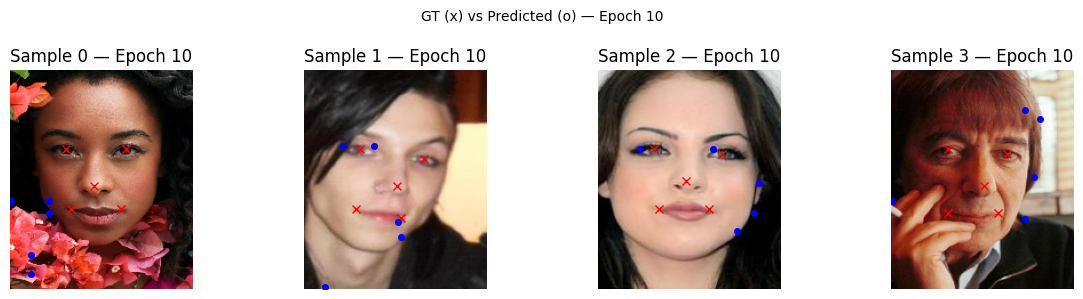

Epoch 11/100, Train Loss: 0.0245
Epoch 11/100, Validation Loss: 0.0202
Model saved (epoch 11, val_loss=0.0202)


Epoch 12/100, Train Loss: 0.0218
Epoch 12/100, Validation Loss: 0.0233


Epoch 13/100, Train Loss: 0.0200
Epoch 13/100, Validation Loss: 0.0172
Model saved (epoch 13, val_loss=0.0172)


Epoch 14/100, Train Loss: 0.0188
Epoch 14/100, Validation Loss: 0.0156
Model saved (epoch 14, val_loss=0.0156)


Epoch 15/100, Train Loss: 0.0169
Epoch 15/100, Validation Loss: 0.0139
Model saved (epoch 15, val_loss=0.0139)


Epoch 16/100, Train Loss: 0.0173
Epoch 16/100, Validation Loss: 0.0136
Model saved (epoch 16, val_loss=0.0136)


Epoch 17/100, Train Loss: 0.0145
Epoch 17/100, Validation Loss: 0.0117
Model saved (epoch 17, val_loss=0.0117)


Epoch 18/100, Train Loss: 0.0135
Epoch 18/100, Validation Loss: 0.0125


Epoch 19/100, Train Loss: 0.0129
Epoch 19/100, Validation Loss: 0.0116
Model saved (epoch 19, val_loss=0.0116)


Epoch 20/100, Train Loss: 0.0121
Epoch 20/100, Validation Loss: 0.0116


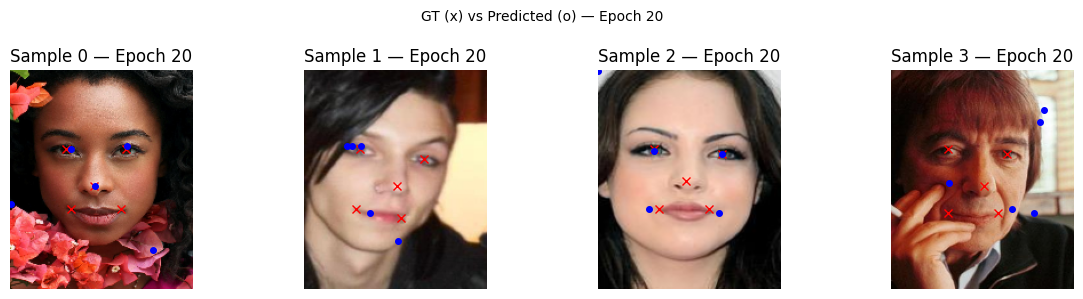

Epoch 21/100, Train Loss: 0.0113
Epoch 21/100, Validation Loss: 0.0101
Model saved (epoch 21, val_loss=0.0101)


Epoch 22/100, Train Loss: 0.0105
Epoch 22/100, Validation Loss: 0.0102


Epoch 23/100, Train Loss: 0.0105
Epoch 23/100, Validation Loss: 0.0093
Model saved (epoch 23, val_loss=0.0093)


Epoch 24/100, Train Loss: 0.0102
Epoch 24/100, Validation Loss: 0.0095


Epoch 25/100, Train Loss: 0.0095
Epoch 25/100, Validation Loss: 0.0093
Model saved (epoch 25, val_loss=0.0093)


Epoch 26/100, Train Loss: 0.0089
Epoch 26/100, Validation Loss: 0.0080
Model saved (epoch 26, val_loss=0.0080)


Epoch 27/100, Train Loss: 0.0090
Epoch 27/100, Validation Loss: 0.0087


Epoch 28/100, Train Loss: 0.0084
Epoch 28/100, Validation Loss: 0.0073
Model saved (epoch 28, val_loss=0.0073)


Epoch 29/100, Train Loss: 0.0081
Epoch 29/100, Validation Loss: 0.0078


Epoch 30/100, Train Loss: 0.0080
Epoch 30/100, Validation Loss: 0.0079


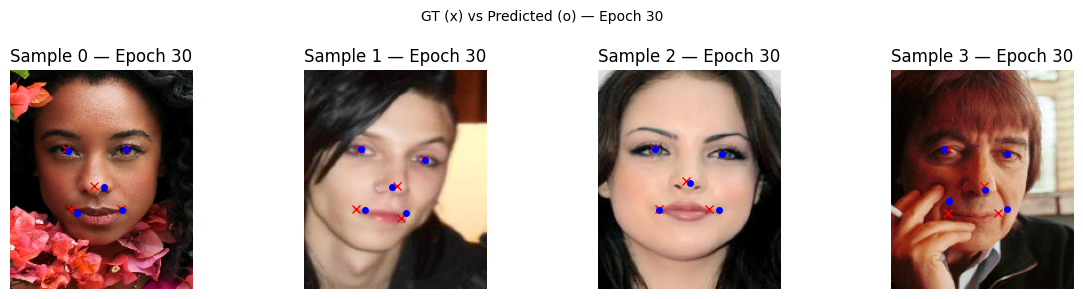

Epoch 31/100, Train Loss: 0.0078
Epoch 31/100, Validation Loss: 0.0065
Model saved (epoch 31, val_loss=0.0065)


Epoch 32/100, Train Loss: 0.0069
Epoch 32/100, Validation Loss: 0.0067


Epoch 33/100, Train Loss: 0.0066
Epoch 33/100, Validation Loss: 0.0062
Model saved (epoch 33, val_loss=0.0062)


Epoch 34/100, Train Loss: 0.0064
Epoch 34/100, Validation Loss: 0.0065


Epoch 35/100, Train Loss: 0.0061
Epoch 35/100, Validation Loss: 0.0062


Epoch 36/100, Train Loss: 0.0063
Epoch 36/100, Validation Loss: 0.0062


Epoch 37/100, Train Loss: 0.0056
Epoch 37/100, Validation Loss: 0.0051
Model saved (epoch 37, val_loss=0.0051)


Epoch 38/100, Train Loss: 0.0054
Epoch 38/100, Validation Loss: 0.0046
Model saved (epoch 38, val_loss=0.0046)


Epoch 39/100, Train Loss: 0.0050
Epoch 39/100, Validation Loss: 0.0049


Epoch 40/100, Train Loss: 0.0045
Epoch 40/100, Validation Loss: 0.0053


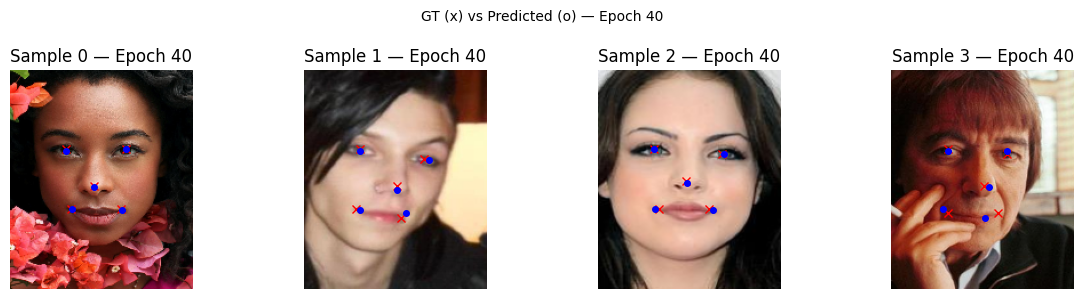

Epoch 41/100, Train Loss: 0.0045
Epoch 41/100, Validation Loss: 0.0045
Model saved (epoch 41, val_loss=0.0045)


Epoch 42/100, Train Loss: 0.0047
Epoch 42/100, Validation Loss: 0.0037
Model saved (epoch 42, val_loss=0.0037)


Epoch 43/100, Train Loss: 0.0041
Epoch 43/100, Validation Loss: 0.0038


Epoch 44/100, Train Loss: 0.0043
Epoch 44/100, Validation Loss: 0.0043


Epoch 45/100, Train Loss: 0.0041
Epoch 45/100, Validation Loss: 0.0026
Model saved (epoch 45, val_loss=0.0026)


Epoch 46/100, Train Loss: 0.0037
Epoch 46/100, Validation Loss: 0.0053


Epoch 47/100, Train Loss: 0.0031
Epoch 47/100, Validation Loss: 0.0040


Epoch 48/100, Train Loss: 0.0034
Epoch 48/100, Validation Loss: 0.0048


Epoch 49/100, Train Loss: 0.0030
Epoch 49/100, Validation Loss: 0.0036


Epoch 50/100, Train Loss: 0.0037
Epoch 50/100, Validation Loss: 0.0027


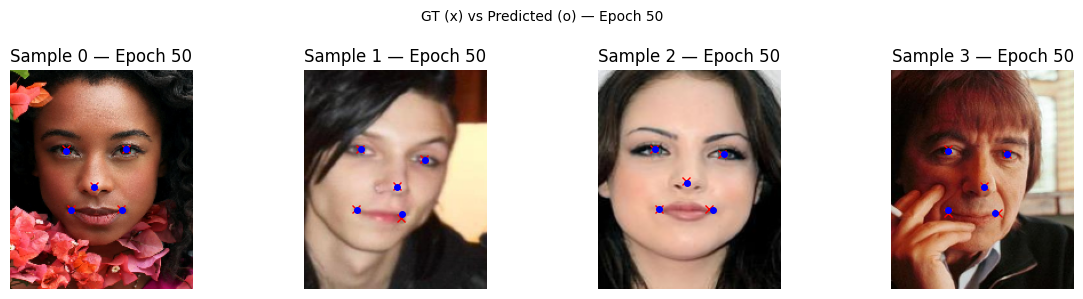

Epoch 51/100, Train Loss: 0.0027
Epoch 51/100, Validation Loss: 0.0026


Epoch 52/100, Train Loss: 0.0026
Epoch 52/100, Validation Loss: 0.0155


Epoch 53/100, Train Loss: 0.0030
Epoch 53/100, Validation Loss: 0.0061


Epoch 54/100, Train Loss: 0.0027
Epoch 54/100, Validation Loss: 0.0023
Model saved (epoch 54, val_loss=0.0023)


Epoch 55/100, Train Loss: 0.0022
Epoch 55/100, Validation Loss: 0.0029


Epoch 56/100, Train Loss: 0.0028
Epoch 56/100, Validation Loss: 0.0043


Epoch 57/100, Train Loss: 0.0028
Epoch 57/100, Validation Loss: 0.0035


Epoch 58/100, Train Loss: 0.0023
Epoch 58/100, Validation Loss: 0.0055


Epoch 59/100, Train Loss: 0.0025
Epoch 59/100, Validation Loss: 0.0027


Epoch 60/100, Train Loss: 0.0022
Epoch 60/100, Validation Loss: 0.0057


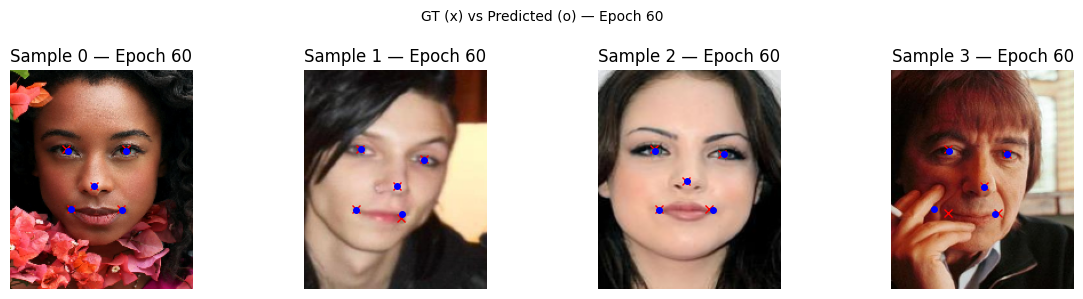

Epoch 61/100, Train Loss: 0.0023
Epoch 61/100, Validation Loss: 0.0034


Epoch 62/100, Train Loss: 0.0017
Epoch 62/100, Validation Loss: 0.0038


Epoch 63/100, Train Loss: 0.0016
Epoch 63/100, Validation Loss: 0.0059


Epoch 64/100, Train Loss: 0.0022
Epoch 64/100, Validation Loss: 0.0155


Epoch 65/100, Train Loss: 0.0024
Epoch 65/100, Validation Loss: 0.0208


Epoch 66/100, Train Loss: 0.0011
Epoch 66/100, Validation Loss: 0.0010
Model saved (epoch 66, val_loss=0.0010)


Epoch 67/100, Train Loss: 0.0010
Epoch 67/100, Validation Loss: 0.0011


Epoch 68/100, Train Loss: 0.0009
Epoch 68/100, Validation Loss: 0.0014


Epoch 69/100, Train Loss: 0.0009
Epoch 69/100, Validation Loss: 0.0011


Epoch 70/100, Train Loss: 0.0009
Epoch 70/100, Validation Loss: 0.0010
Model saved (epoch 70, val_loss=0.0010)


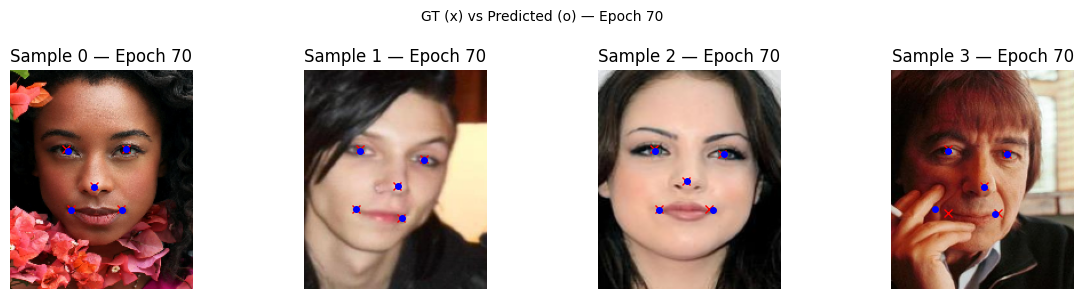

Epoch 71/100, Train Loss: 0.0009
Epoch 71/100, Validation Loss: 0.0011


Epoch 72/100, Train Loss: 0.0009
Epoch 72/100, Validation Loss: 0.0019


Epoch 73/100, Train Loss: 0.0009
Epoch 73/100, Validation Loss: 0.0012


Epoch 74/100, Train Loss: 0.0009
Epoch 74/100, Validation Loss: 0.0012


Epoch 75/100, Train Loss: 0.0009
Epoch 75/100, Validation Loss: 0.0012


Epoch 76/100, Train Loss: 0.0009
Epoch 76/100, Validation Loss: 0.0013


Epoch 77/100, Train Loss: 0.0009
Epoch 77/100, Validation Loss: 0.0012


Epoch 78/100, Train Loss: 0.0009
Epoch 78/100, Validation Loss: 0.0014


Epoch 79/100, Train Loss: 0.0009
Epoch 79/100, Validation Loss: 0.0020


Epoch 80/100, Train Loss: 0.0009
Epoch 80/100, Validation Loss: 0.0012


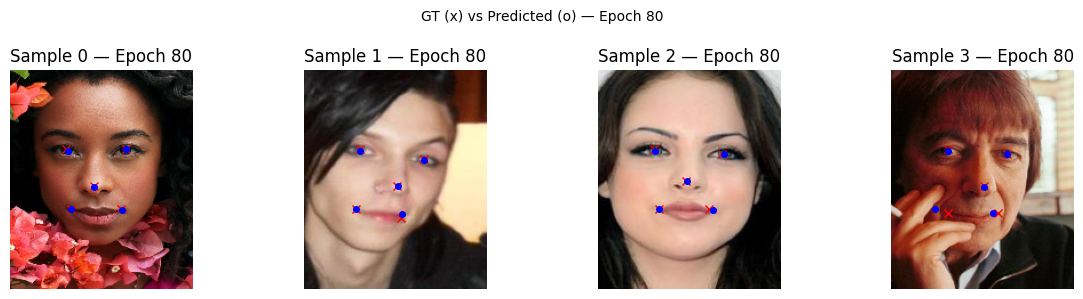

Epoch 81/100, Train Loss: 0.0008
Epoch 81/100, Validation Loss: 0.0015


Epoch 82/100, Train Loss: 0.0008
Epoch 82/100, Validation Loss: 0.0016


Epoch 83/100, Train Loss: 0.0008
Epoch 83/100, Validation Loss: 0.0011


Epoch 84/100, Train Loss: 0.0008
Epoch 84/100, Validation Loss: 0.0011


Epoch 85/100, Train Loss: 0.0008
Epoch 85/100, Validation Loss: 0.0010


Epoch 86/100, Train Loss: 0.0008
Epoch 86/100, Validation Loss: 0.0010


Epoch 87/100, Train Loss: 0.0008
Epoch 87/100, Validation Loss: 0.0011


Epoch 88/100, Train Loss: 0.0008
Epoch 88/100, Validation Loss: 0.0009
Model saved (epoch 88, val_loss=0.0009)


Epoch 89/100, Train Loss: 0.0008
Epoch 89/100, Validation Loss: 0.0012


Epoch 90/100, Train Loss: 0.0008
Epoch 90/100, Validation Loss: 0.0011


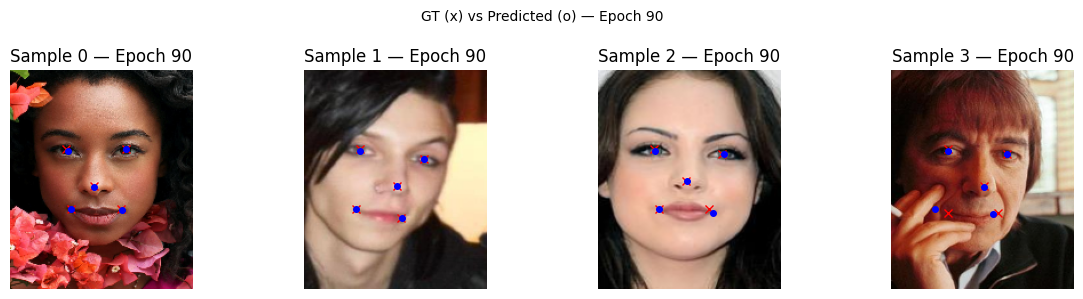

Epoch 91/100, Train Loss: 0.0008
Epoch 91/100, Validation Loss: 0.0011


Epoch 92/100, Train Loss: 0.0008
Epoch 92/100, Validation Loss: 0.0011


Epoch 93/100, Train Loss: 0.0008
Epoch 93/100, Validation Loss: 0.0009


Epoch 94/100, Train Loss: 0.0008
Epoch 94/100, Validation Loss: 0.0010


Epoch 95/100, Train Loss: 0.0008
Epoch 95/100, Validation Loss: 0.0010


Epoch 96/100, Train Loss: 0.0008
Epoch 96/100, Validation Loss: 0.0010


Epoch 97/100, Train Loss: 0.0008
Epoch 97/100, Validation Loss: 0.0010


Epoch 98/100, Train Loss: 0.0008
Epoch 98/100, Validation Loss: 0.0014


Epoch 99/100, Train Loss: 0.0008
Epoch 99/100, Validation Loss: 0.0014


Epoch 100/100, Train Loss: 0.0008
Epoch 100/100, Validation Loss: 0.0015


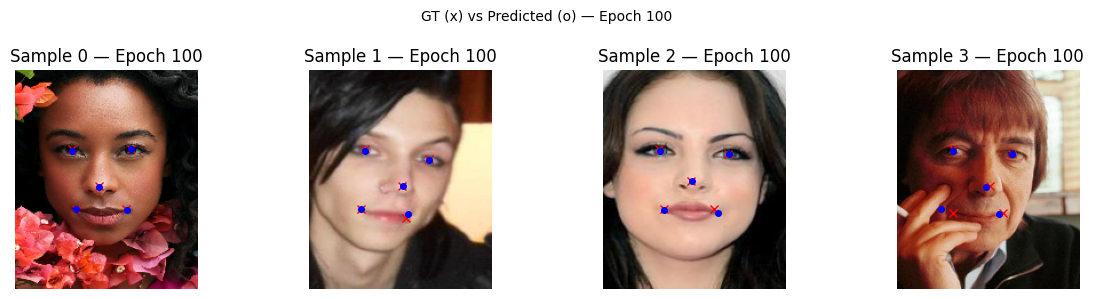

In [22]:
from tqdm import tqdm  # импортируем tqdm
num_epochs = 100

best_val_loss = float('inf')  # <-- начальный минимум
checkpoint_path = "best_model.pth"

fixed_images, fixed_heatmaps = next(iter(val_loader))
fixed_images = fixed_images.to(device)
fixed_heatmaps = fixed_heatmaps.to(device)

train_loss = []
val_loss = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for images, heatmaps in loop:
        images = images.to(device)
        heatmaps = heatmaps.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = model.calc_loss(outputs, heatmaps)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Валидация
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, heatmaps in val_loader:
            images = images.to(device)
            heatmaps = heatmaps.to(device)
            outputs = model(images)
            loss = model.calc_loss(outputs, heatmaps)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_loss.append(avg_val_loss)
    print(f"Epoch {epoch}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Шедулер обновляем по валидационному лоссу
    scheduler.step(avg_val_loss)

    # === Сохраняем лучшую модель ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved (epoch {epoch}, val_loss={avg_val_loss:.4f})")

    # Визуализация каждые 5 эпох (пример)
    if epoch % 10 == 0:
        with torch.no_grad():
            preds = model(fixed_images)
            visualize(
                fixed_images.cpu(),
                fixed_heatmaps.cpu(),
                preds[:, -1].cpu(),  # последний стек
                epoch
            )




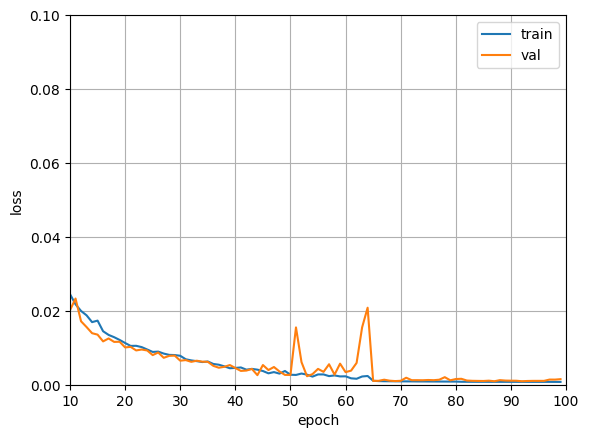

In [23]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(10, 100)
plt.ylim(0, 0.1)
plt.grid()
plt.show()

In [24]:
# Сохраним модель
#torch.save(model, 'model_FaceAligment.pth')

In [24]:
# Загрузим модель
model = LandmarksNet()
model.load_state_dict(torch.load("best_model_FaceAligment.pth"))
model.to(device)
model.eval()

LandmarksNet(
  (pre): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResidualBlock(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResidualBlock(
      (skip): Identity()
      (conv1): Conv2d(128, 64, kernel_size=(1, 1)

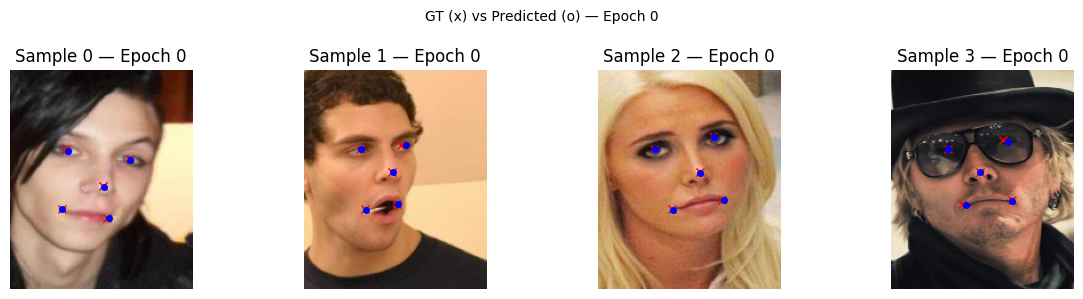

In [ ]:
# Тест на тесте

with torch.no_grad():
    images, heatmaps = next(iter(val_loader))
    images = images.to(device)
    heatmaps = heatmaps.to(device)
    preds = model(images)
    visualize(
    images.cpu(),
    heatmaps.cpu(),
    preds[:, -1].cpu(),  # последний стек
           0)

# Выравнивание по предсказанным точкам

Найдем средний шаблон (Mean Template) - Наиболее точный и адаптивный к датасету:

-Нормализовать landmarks по масштабу и положению (например, глаза — на фиксированном расстоянии).
-Найти среднее положение по всем изображениям — это и будет "шаблон".

In [25]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from skimage.transform import SimilarityTransform, warp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [36]:
bbox_dir=r".\dataset_500\list_bbox_celeba.txt"
landmarks_df=r".\dataset_500\list_landmarks_celeba.txt"

train_dir = r".\dataset_500\Wild\train"
val_dir = r".\dataset_500\Wild\val"
test_dir = r".\dataset_500\Wild\test"

In [30]:
def predict_landmarks(
    image_rgb,
    img_name,
    model,
    bbox_df,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    image_size=(160, 192)
):
    """
    Предсказание 5 landmarks без выравнивания.

    :return: pred_landmarks — np.ndarray (5, 2)
    """
    # Получаем bbox
    bbox = bbox_df.set_index("image_id").loc[img_name]
    x, y, w, h = int(bbox['x_1']), int(bbox['y_1']), int(bbox['width']), int(bbox['height'])

    # Кроп и ресайз
    image_crop = image_rgb[y:y+h, x:x+w]
    resized = cv2.resize(image_crop, image_size)
    input_tensor = torch.tensor(resized.astype(np.float32) / 255.).permute(2, 0, 1).unsqueeze(0).to(device)

    # Предсказание
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)           # [1, N, 5, H, W]
        heatmaps = output[:, -1]               # [1, 5, H, W]

    heatmaps = F.interpolate(heatmaps, size=(image_size[1], image_size[0]), mode='bilinear', align_corners=False)
    heatmaps = heatmaps.squeeze(0).cpu().numpy()  # [5, H, W]

    pred_landmarks = []
    for i in range(5):
        y_hm, x_hm = np.unravel_index(np.argmax(heatmaps[i]), heatmaps[i].shape)
        pred_landmarks.append([x_hm, y_hm])

    return np.array(pred_landmarks, dtype=np.float32)

# Предварительно загружаем данные
img_list = [f for f in os.listdir(val_dir) if f.endswith(".jpg")]
img_name = random.choice(img_list)

img_path = os.path.join(val_dir, img_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

bbox_df = pd.read_csv(bbox_dir, sep='\s+', header=1)

# Запускаем
#predict_landmarks(image_rgb, img_name, model, bbox_df)

<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VolkovAP\AppData\Local\Temp\ipykernel_16484\4294656229.py:47: SyntaxWarning: invalid escape sequence '\s'
  bbox_df = pd.read_csv(bbox_dir, sep='\s+', header=1)


In [31]:
from glob import glob

image_paths = sorted(glob(os.path.join(train_dir, "*.jpg")))

all_aligned_landmarks = []

for img_path in tqdm(image_paths):
    # === Загрузка RGB изображения
    img_name = os.path.basename(img_path)
    image_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    try:
        # Получаем выровненные landmarks
        aligned_landmarks = predict_landmarks(
            image_rgb=image_rgb,
            img_name=img_name,
            model=model,
            bbox_df=bbox_df)
        all_aligned_landmarks.append(aligned_landmarks)

    except Exception as e:
        print(f"[!] Error on {img_name}: {e}")
        continue

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [07:43<00:00, 26.99it/s]


In [32]:
# Преобразуем список в массив
landmarks_array = np.stack(all_aligned_landmarks, axis=0)  # (N, 5, 2)

# Средний шаблон
mean_template = np.mean(landmarks_array, axis=0)  # (5, 2)

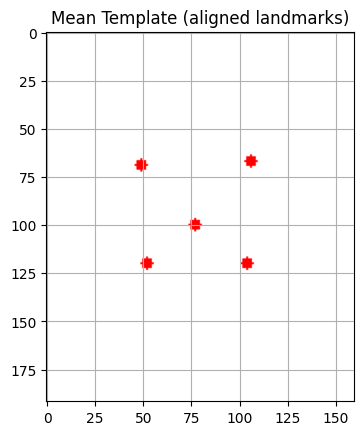

In [33]:
def show_template(landmarks, image_size=(160, 192)):
    canvas = np.ones((image_size[1], image_size[0], 3), dtype=np.uint8) * 255
    for (x, y) in landmarks.astype(int):
        cv2.circle(canvas, (x, y), 3, (255, 0, 0), -1)
    plt.imshow(canvas)
    plt.title("Mean Template (aligned landmarks)")
    plt.grid()
    plt.show()

show_template(mean_template)

In [34]:
mean_template

array([[ 49.55128,  69.48456],
       [106.11472,  67.97448],
       [ 77.49944, 100.23768],
       [ 52.93336, 120.95176],
       [104.39072, 120.3276 ]], dtype=float32)

<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:91: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VolkovAP\AppData\Local\Temp\ipykernel_16484\1146111171.py:91: SyntaxWarning: invalid escape sequence '\s'
  bbox_df = pd.read_csv(bbox_dir, sep='\s+', header=1)


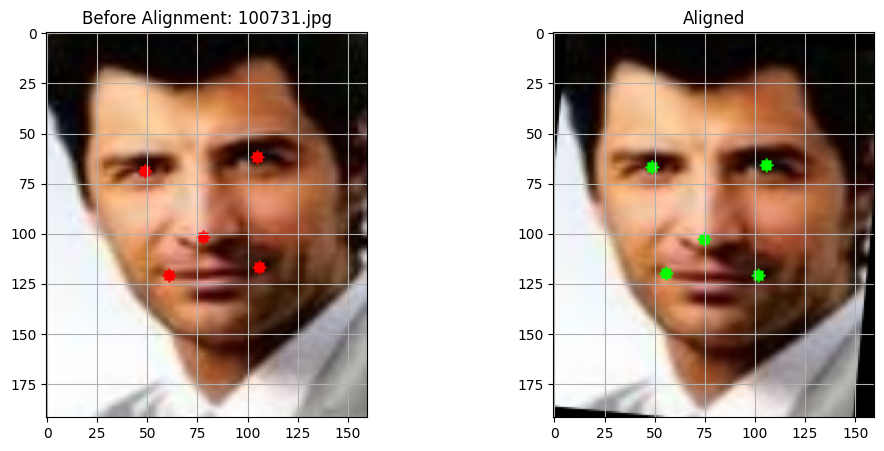

In [41]:
def predict_and_align(
    image_rgb,
    img_name,
    model,
    bbox_df,
    template=mean_template,
    show=True,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    image_size=(160, 192)
):
    """
    Предсказание landmarks и выравнивание шаблону, используя готовое изображение и имя.

    :param image_rgb: np.ndarray (H, W, 3) — исходное RGB изображение
    :param img_name: строка — имя изображения (для поиска bbox)
    :param model: torch-модель
    :param bbox_df: DataFrame с bbox аннотациями
    :param show: показывать результат или возвращать
    :return: (aligned_image, aligned_landmarks) если show=False
    """

    # === Получаем bbox ===
    bbox = bbox_df.set_index("image_id").loc[img_name]
    x, y, w, h = int(bbox['x_1']), int(bbox['y_1']), int(bbox['width']), int(bbox['height'])

    # === Crop + resize
    image_crop = image_rgb[y:y+h, x:x+w]
    resized = cv2.resize(image_crop, image_size)  # (160x192)
    input_tensor = torch.tensor(resized.astype(np.float32) / 255.).permute(2, 0, 1).unsqueeze(0).to(device)

    # === Предсказание heatmaps
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)           # [1, N, 5, 48, 40]
        heatmaps_pred = output[:, -1]          # [1, 5, 48, 40]

    upsampled = F.interpolate(heatmaps_pred, size=(image_size[1], image_size[0]), mode='bilinear', align_corners=False)
    upsampled = upsampled.squeeze(0).cpu().numpy()  # [5, H, W]

    # === Извлекаем landmarks
    pred_landmarks = []
    for i in range(5):
        y_hm, x_hm = np.unravel_index(np.argmax(upsampled[i]), upsampled[i].shape)
        pred_landmarks.append([x_hm, y_hm])
    pred_landmarks = np.array(pred_landmarks, dtype=np.float32)



    # === Выравнивание изображения
    tform = SimilarityTransform()
    if not tform.estimate(pred_landmarks, template):
        raise ValueError("Не удалось найти similarity transform.")
    aligned = warp(resized, tform.inverse, output_shape=(image_size[1], image_size[0]), preserve_range=True).astype(np.uint8)

    # === Преобразование landmarks → в aligned-изображение
    aligned_landmarks = tform(pred_landmarks)  # <<<<<< ВАЖНО!

    # === Отрисовка
    if show:
        vis1 = resized.copy()
        vis2 = aligned.copy()
        for (x_lm, y_lm) in pred_landmarks.astype(int):
            cv2.circle(vis1, (x_lm, y_lm), 3, (255, 0, 0), -1)
        for (x_lm, y_lm) in aligned_landmarks.astype(int):
            cv2.circle(vis2, (x_lm, y_lm), 3, (0, 255, 0), -1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(vis1)
        plt.title(f"Before Alignment: {img_name}")
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.imshow(vis2)
        plt.title("Aligned")
        plt.grid()
        plt.show()
        return

    else:
        return aligned, aligned_landmarks

# Предварительно загружаем данные
img_dir = r".\dataset_1000\Wild\test"
img_list = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
img_name = random.choice(img_list)

img_path = os.path.join(img_dir, img_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

bbox_df = pd.read_csv(bbox_dir, sep='\s+', header=1)

# Запускаем
predict_and_align(image_rgb, img_name, model, bbox_df, show=True)


In [44]:
# Подготовим наш датасет

from tqdm import tqdm

# Пути
input_dir = r".\dataset_500\Wild\train"
output_dir = r".\dataset_500\My_Aligned\train"
bbox_path = r".\dataset_500\list_bbox_celeba.txt"

# Загрузка bbox
bbox_df = pd.read_csv(bbox_path, sep='\s+', header=1)

# Создаём выходную директорию, если нужно
os.makedirs(output_dir, exist_ok=True)

# Список изображений
img_list = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]

# Обработка всех изображений
for img_name in tqdm(img_list, desc="Обработка изображений"):
    img_path = os.path.join(input_dir, img_name)

    # Чтение изображения
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"❌ Пропущено: {img_name} (не удалось загрузить)")
        continue
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    try:
        # Выравнивание лица без отображения
        aligned_face, _ = predict_and_align(
            image_rgb=image_rgb,
            img_name=img_name,
            model=model,
            bbox_df=bbox_df,
            template=mean_template,
            show=False  # не показываем
        )

        # Сохраняем как BGR JPG
        out_path = os.path.join(output_dir, img_name)
        face_bgr = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)
        cv2.imwrite(out_path, face_bgr)

    except Exception as e:
        print(f"⚠️ Ошибка на {img_name}: {e}")


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VolkovAP\AppData\Local\Temp\ipykernel_16484\4245030377.py:11: SyntaxWarning: invalid escape sequence '\s'
  bbox_df = pd.read_csv(bbox_path, sep='\s+', header=1)
Обработка изображений: 100%|█████████████████████████████████████████████████████| 12500/12500 [09:28<00:00, 21.99it/s]


# Conclusion
Обучена модель Stacked Hourglass Network для определения 5 ключевых точек лица. Лучшая точность на вылидации val_loss=0.0009
Для обучения использовался Celeba in the wild датасет так как обучение на Celeba_aligned не позволяли предсказывать ключевые точки из wild датасета